In [1]:
#Генерация данных для таблицы PostgreSQL
import faker
from faker import Faker
from string import Template
fake = Faker()
tmpl = Template("INSERT INTO email(email, password) VAlUES $VALUES;")
args = {"VALUES": []}
emails = ["'" + str(fake.email()) + "'" for i in range(12)]
passwords = ["'" + str(fake.password()) + "'" for i in range(12)]

raw_data = list(map(lambda x: f"({x[0]}, {x[1]})", list(zip(emails, passwords))))
data = ",\n".join(raw_data)+";"
args["VALUES"] = data[:-1]
sql = tmpl.substitute(**args)
with open("email.sql", "wt") as fp:
    fp.write(sql)

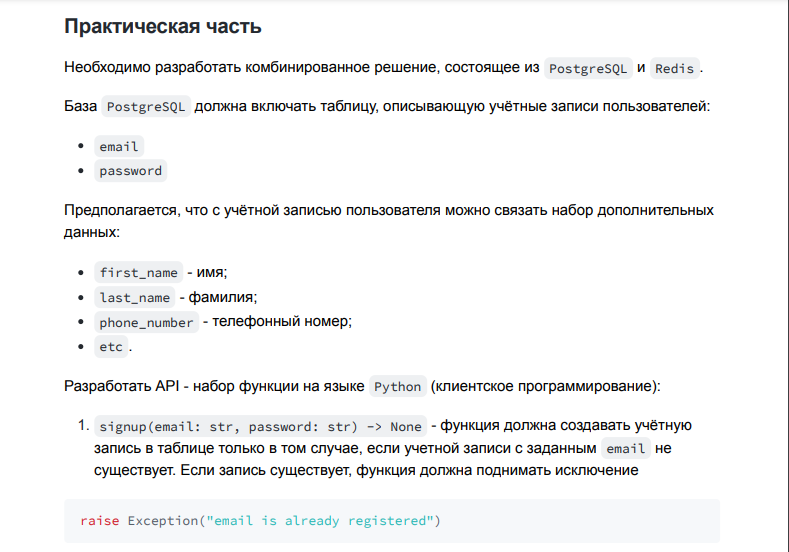

In [2]:
import json
import psycopg2

def read_config():
    with open('conf.json', 'r') as file:
        config = json.load(file)
    return config

def signup(email: str, password: str) -> None:
    conf = read_config()
    conn  = psycopg2.connect(
    user = conf['user'],
    password = conf['password'],
    host = conf['host'],
    port = conf['port'],
    database = conf['database']
    )
    try:
        cursor = conn.cursor()

        cursor.execute("SELECT COUNT(*) FROM email WHERE email = %s", (email,))
        count = cursor.fetchone()[0]

        if count == 0:
            cursor.execute("INSERT INTO email (email, password) VALUES (%s, %s)", (email, password))
            conn.commit()
        else:
            raise Exception("email is already registered")
    finally:
        cursor.close()
        conn.close()

try:
    signup("example1@email.com", "password123")
    print("Account created successfully!")
except Exception as e:
    print(f"Error: {e}")


Error: email is already registered


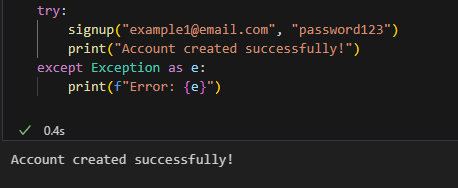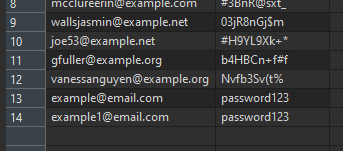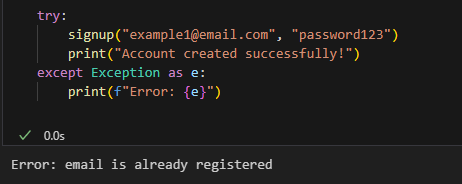

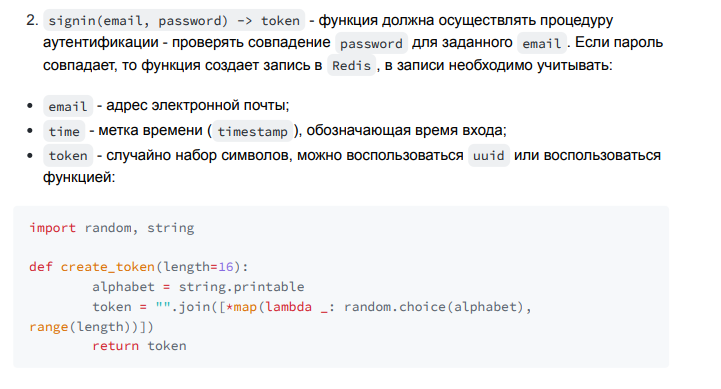

In [38]:
import redis
import uuid
import time
import json
import psycopg2

def read_config():
    with open('conf.json', 'r') as file:
        config = json.load(file)
    return config

def signin(email, password) -> str:

    r = redis.StrictRedis(
    host="192.168.0.20",
    username="client",
    password="1234",
    port=6379,
    charset="utf-8",
    decode_responses=True,
    )

    conf = read_config()
    conn  = psycopg2.connect(
    user = conf['user'],
    password = conf['password'],
    host = conf['host'],
    port = conf['port'],
    database = conf['database']
    )

    try:
        cursor = conn.cursor()

        cursor.execute("SELECT email FROM email WHERE email = %s AND password = %s", (email, password))
        result = cursor.fetchone()
        if result is not None:
            token = str(uuid.uuid4())
            timestamp = int(time.time())
            redis_value = json.dumps({'email': email, 'password': password, 'timestamp': timestamp})
            r.set(token, redis_value)
            return token
        else:
            raise Exception("Invalid credentials")

    finally:
        cursor.close()
        conn.close()

try:
    token = signin("example@email.com", "password123")
    print(f"Authentication successful. Token: {token}")
except Exception as e:
    print(f"Error: {e}")


Authentication successful. Token: 35be8082-6a5c-4611-809c-924109f6f361


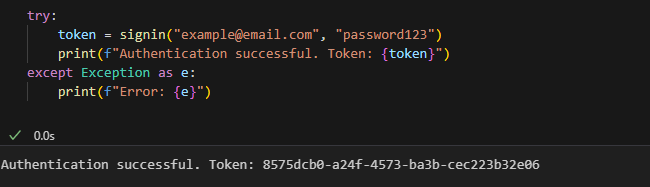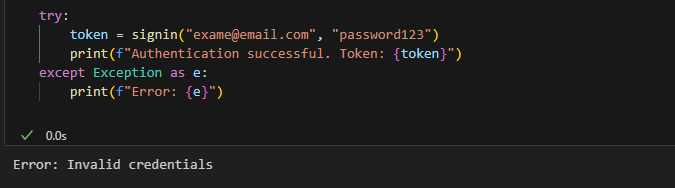

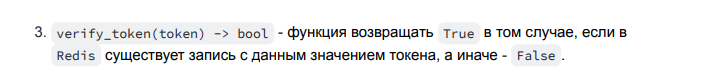

In [36]:
import redis

def verify_token(token) -> bool:
    r = redis.StrictRedis(
        host="192.168.0.20",
        username="client",
        password="1234",
        port=6379,
        charset="utf-8",
        decode_responses=True,
    )

    return r.exists(token)

token_to_verify = "50ef088b-7888-4704-b343-1f89034afdcb"
if verify_token(token_to_verify):
    print("Токен действителен. Пользователь аутентифицирован.")
else:
    print("Токен недействителен. Пользователь не аутентифицирован.")


Токен действителен. Пользователь аутентифицирован.


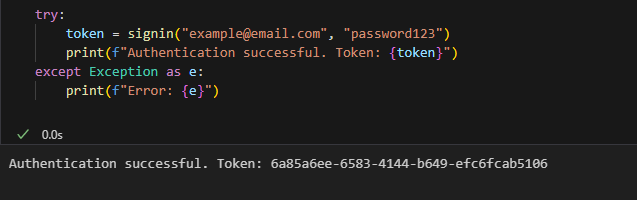
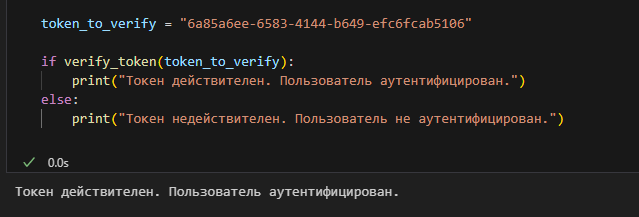                                              
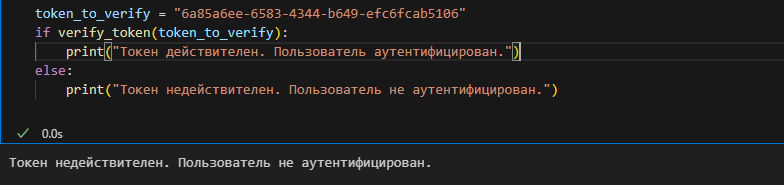

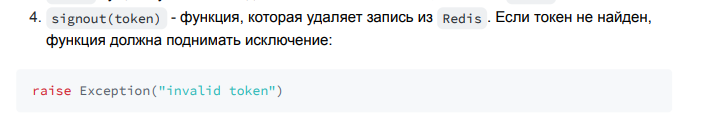

In [37]:
def signout(token):
    r = redis.StrictRedis(
        host="192.168.0.20",
        username="client",
        password="1234",
        port=6379,
        charset="utf-8",
        decode_responses=True,
    )

    if r.exists(token):
        r.delete(token)
    else:
        raise Exception("Токен не найден")
    

token_to_signout = "50ef088b-7888-4704-b343-1f89034afdcb"
try:
    signout(token_to_signout)
    print("Пользователь вышел из системы. Токен удален.")
except Exception as e:
    print(f"Ошибка: {e}")


Пользователь вышел из системы. Токен удален.


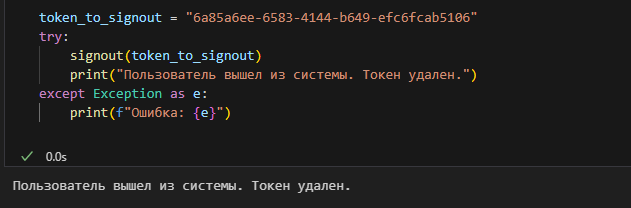                                                  
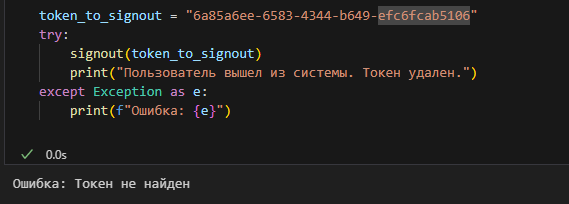

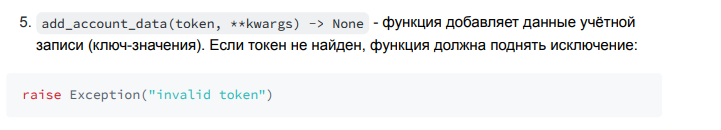

In [39]:
def add_account_data(token, **kwargs):
    r = redis.StrictRedis(
        host="192.168.0.20",
        username="client",
        password="1234",
        port=6379,
        charset="utf-8",
        decode_responses=True,
    )

    if r.exists(token):
        account_data_json = json.dumps(kwargs)
        r.set(token, account_data_json)
    else:
        raise Exception("Токен не найден")
    

token_to_update = "35be8082-6a5c-4611-809c-924109f6f361"
account_data_to_add = {
    "username": "john_doe",
    "age": 30
}

try:
    add_account_data(token_to_update, **account_data_to_add)
    print("Данные учетной записи успешно обновлены.")
except Exception as e:
    print(f"Ошибка: {e}")

Данные учетной записи успешно обновлены.


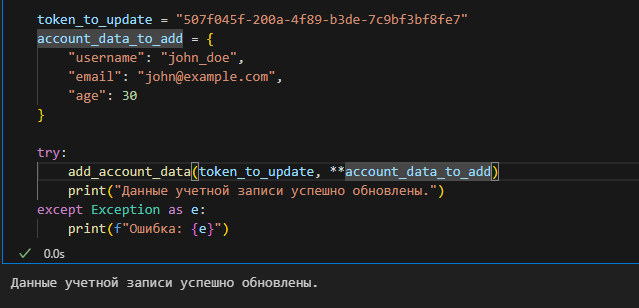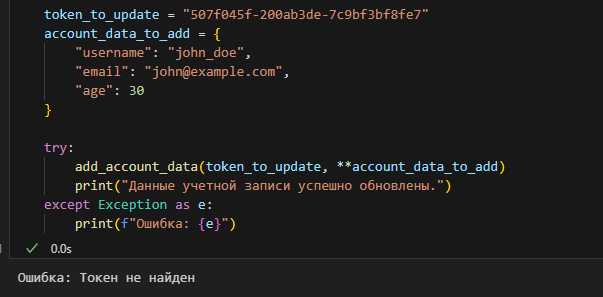

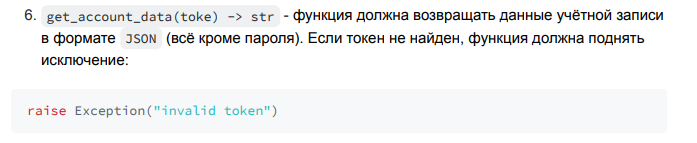

In [40]:
def get_account_data(token) -> str:
    r = redis.StrictRedis(
        host="192.168.0.20",
        username="client",
        password="1234",
        port=6379,
        charset="utf-8",
        decode_responses=True,
    )

    if r.exists(token):
        account_data_json = r.get(token)
        account_data = json.loads(account_data_json)
        account_data.pop('password', None)
        return json.dumps(account_data)
    else:
        raise Exception("Токен не найден")

token_to_get_data = "35be8082-6a5c-4611-809c-924109f6f361"

try:
    account_data = get_account_data(token_to_get_data)
    print("Данные учетной записи:")
    print(account_data)
except Exception as e:
    print(f"Ошибка: {e}")


Данные учетной записи:
{"username": "john_doe", "age": 30}


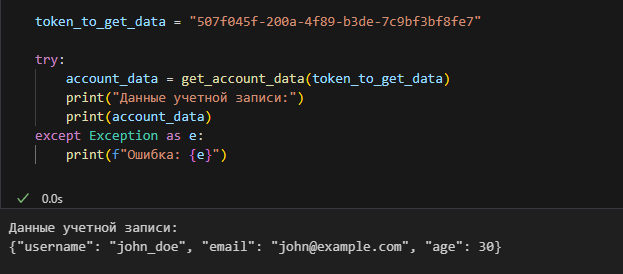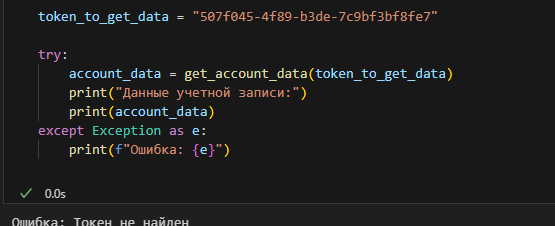